In [3]:
!pip install pydot
!pip uninstall keras -y
# !pip install keras==2.1.2
!pip install keras

You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Uninstalling Keras-2.1.2:
  Successfully uninstalled Keras-2.1.2
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 378kB 34.5MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import keras
import sagemaker
from keras.models import load_model
import numpy as np
import os

import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf

from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
from keras.models import model_from_json
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Input, Embedding, Flatten, Dot, Dense, LSTM, Activation
from keras.models import Model
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential

warnings.filterwarnings('ignore')
%matplotlib inline
sess = sagemaker.Session()
role = sagemaker.get_execution_role()


Using TensorFlow backend.


### Load the model artifact from disk and get a visual representation 
Make sure you're pointing to the model that we provided in the repo: ```model.h5```

In [13]:
!gunzip model.h5

download: s3://strata-workshop/model-data/full-model-v3.h5 to ./full-model-v3.h5


In [2]:
loaded_model = load_model('model.h5')

W0924 14:07:23.466201 140467096815424 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0924 14:07:24.844958 140467096815424 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



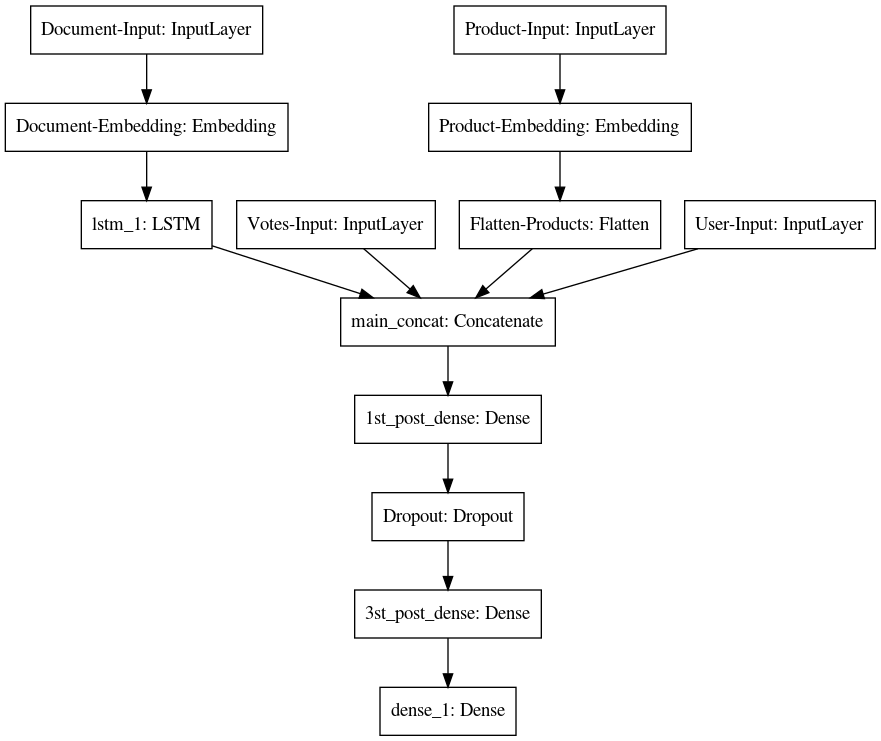

In [3]:
from keras.utils import plot_model
plot_model(loaded_model, to_file='img-model.png')

### Download the test data and run predictions against your endpoint

In [4]:
def read_data(f_name):
    
    df = pd.read_csv(f_name, sep='\t', nrows = 1000)
        
    df['docs_to_embed'] = df['product_title'] + ', ' + df['review_headline'] + ', ' + df['review_body']
    
    df.drop(['product_title', 'review_headline', 'review_body'], axis=1, inplace=True)
    
    # remove nans
    df.dropna(inplace=True)
    
#     df['customer_id'] = str(df['customer_id'])
 
    return df

df = read_data('micro_data.tsv')


In [5]:
def get_label(df):
    labels = [1 if int(x) >= 4 else 0 for x in df['star_rating'] ]
    return labels

def get_encoded_ids(df, id_name):

    assert id_name in ['product_id', 'docs_to_embed']
    
    if id_name == 'product_id':
        vocab_size = 4412
    
    elif id_name == 'docs_to_embed':
        vocab_size = 34467
    
    docs = df[id_name].values.tolist()
        
    encoded_ids = [one_hot(d, vocab_size) for d in docs]

    return np.array(encoded_ids)

def get_padded_documents(df):
    encoded_docs = get_encoded_ids(df, 'docs_to_embed')
    
    max_length = 2261
    
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    
    return padded_docs


labels = get_label(df)


In [6]:
def get_model_input_specs(df):
    n_users = 9928
    n_products = 4412
    max_length = 2261
    vocab_size = 34467

    return vocab_size, max_length, n_users, n_products

def get_scaled(df, col_name):
    x = [int(x) for x in df[col_name]]
    
    x = np.reshape(x, (-1, 1))

    scaler_x = MinMaxScaler()

    scaler_x.fit(x)
    
    xscale = scaler_x.transform(x)

    return xscale

def get_model_input_data(df):
    
    padded_docs = get_padded_documents(df)
    
    encoded_product_ids = get_encoded_ids(df, 'product_id')

    votes = get_scaled(df, 'total_votes')
    
    return [padded_docs, votes, encoded_product_ids, df['customer_id']]

### Now, retrain the model using  the data you just labeled

In [12]:
for layer in loaded_model.layers[:-1]:
    layer.trainable=False

for layer in loaded_model.layers[-2:]:
    layer.trainable=True

In [14]:
# get the new data from the labeling job

df = pd.read_csv('../gt_label_sample_output.csv', sep='\t', names=['customer_id', 'product_id', 'product_title', 'product_category', 'star_rating', 'total_votes', 'review_headline', 'review_body'])

df['docs_to_embed'] = df['product_title'] + ', ' + df['review_headline'] + ', ' + df['review_body']

df.drop(['product_title', 'review_headline', 'review_body'], axis=1, inplace=True)

# remove nans
df.dropna(inplace=True)

In [15]:
new_data_input  = get_model_input_data(df)

In [16]:
new_labels = get_label(df)

In [17]:
history = loaded_model.fit(new_data_input, new_labels, epochs=1, verbose=1, validation_split=0.2)  

loaded_model.save('/home/ec2-user/SageMaker/transfer-model.h5')

# write to json 
json_string = loaded_model.to_json()
with open("transfer-model.json", "w") as json_file:
    json_file.write(json_string)

# save weights
loaded_model.save_weights('transfer-model.h5')

Train on 22 samples, validate on 6 samples
Epoch 1/1
22/22 [==============================] - 11s 483ms/step - loss: 4.0061 - val_loss: 1.4404


### Now use the test data against the new model you just trained using your labeled data

In [18]:
y_pred = loaded_model.predict(data_input)

In [20]:
y_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

Ah, looks like all of the predictions we're getting are positive. On the plus side, this means our recall is 100%! On the downside, it means the recommender isn't adding too much value yet. There are a few reasons this could be the case:
1. Not having enough data in the original training job
2. Not training the original model for a sufficient number of epochs
3. Not having enough labeled data in the per-person ground truth labelling set.

In the real world, you could continue chasing these potential causes of failure until you get a better model. Or, you could move up the stack to a managed service that will handle getting recommendations for you. Welcome to Personalize.